# Learning along a trajectory
In this class, we show how to learn in cases where we don't know the environment nor have access to a simulator. We can only sample trajectories from the starting state
- Q-Learning
- SARSA
- SARSA(lambda)

In [1]:
# To run cells, push MAJ-ENTER or click on the play button at the left of the cells
# Please turn-off AI: from the Tools menu, select Settings, followed by AI assistance. In that space, you'll be able to revoke consent and hide AI coding features.

In [2]:
# Let us first install gymnasium
!pip install swig gymnasium matplotlib scikit-learn
!pip install rlclass --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rlclass: filename=rlclass-0.0.5-py3-none-any.whl size=5633 sha256=0ff20b1b8542a09cfd814d237f376a514128d67df4fe37071333d7b14ee47f44
  Stored in directory: /root/.cache/pip/wheels/76/84/61/5a2d122e9c164814a8710db30005a9e11e5d30d2d0f06c1e52
Successfully built rlclass


In [3]:
# Many environment are available
import gymnasium
gymnasium.envs.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v3', 'LunarLanderContinuous-v3', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v3', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Reacher-v5', 'Pusher-v2', 'Pusher-v4', 'Pusher-v5', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'HalfCheetah-v5', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Hopper-v5', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Swimmer-v5', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Walker2d-v5', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'Humanoid-v5

We will play in the Frozen Lake environment.

# Frozen Lake
Frozen lake involves crossing a frozen lake from start to goal without falling into any holes by walking over the frozen lake.

#Description

The game starts with the player at location [0,0] of the frozen lake grid world with the goal located at far extent of the world e.g. [3,3] for the 4x4 environment.

Holes in the ice are distributed in set locations when using a pre-determined map or in random locations when a random map is generated.

The player makes moves until they reach the goal or fall in a hole.

Randomly generated worlds will always have a path to the goal.

Elf and stool from https://franuka.itch.io/rpg-snow-tileset. All other assets by Mel Tillery http://www.cyaneus.com/.

## Action Space

The action shape is (1,) in the range {0, 3} indicating which direction to move the player.

    0: Move left

    1: Move down

    2: Move right

    3: Move up

## Observation Space

The observation is a value representing the player’s current position as current_row * ncols + current_col (where both the row and col start at 0).The observation is returned as an int().

## Starting State

The episode starts with the player in state [0] (location [0, 0]).
Rewards

## Reward schedule:

    Reach goal: +1

    Reach hole: 0

    Reach frozen: 0

## Episode End

The episode ends if the following happens:

    Termination:

        The player moves into a hole.

        The player reaches the goal at max(nrow) * max(ncol) - 1 (location [max(nrow)-1, max(ncol)-1]).


In [4]:
import numpy
import matplotlib.pyplot as plt

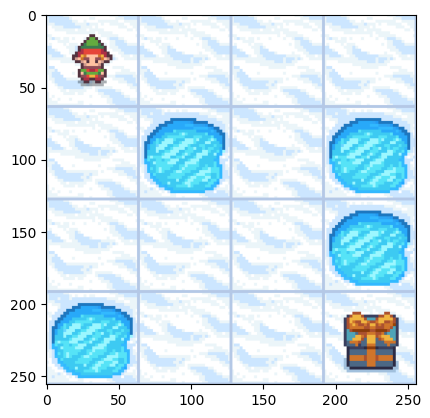

In [5]:
env = gymnasium.make('FrozenLake-v1', render_mode="rgb_array", is_slippery=False)
s0, _ = env.reset()
plt.imshow(env.render())

In [6]:
from rlclass.utils import make_animation

In this class, we will only use deterministic policies so that we can represent a policy by a vector in $\pi \in A^S$

In [7]:
import numpy as np
#  an example
n_states, n_actions = env.observation_space.n, env.action_space.n
pi = np.random.choice(n_actions, size=n_states)

def play_policy(env, pi, horizon=10):
  s, _ = env.reset()
  a = pi[s]
  imgs = []
  imgs.append(env.render())
  for _ in range(horizon):
    s, rew, term, trunc, _ = env.step(a)
    a = pi[s]
    imgs.append(env.render())
  return make_animation(imgs)

play_policy(env, pi)

In [8]:
# To check that our methods will work, we will compare to the optimal policy (found using the model)
from rlclass.td2 import policy_iteration, compute_qpi, compute_vpi
n_iterations = 100
gamma=0.9
pi_star = policy_iteration(env, n_iterations, gamma)
v_star = compute_vpi(env, pi_star, gamma)
play_policy(env, np.argmax(pi_star, axis=0))

# Q-Learning

Q learning is an off-policy method meaning that the policy played (called the *behavior policy*) does not have to be the same policy as the one learned (the *target policy*).

Q learning is a value iteration algorithm where the policy evaluation operator is replaced by a stochastic approximation based on TD(0). More precisely, let us denote $\pi'$ the behavior policy, $\pi$ the target policy. The Q-learning iterations are given by:
- $Q_0 = 0_{|S| \times |A|}$
- For any $t \geq 0$:
  - observe state $s_t$, play action $a_t \sim \pi'_t(s_t)$, observe next state $s_{t+1} \sim P_{a_t}(s_t)$ and reward $r_{a_t}(s_t)$
  - *Policy improvement*:
    - choose $\pi_t$ greedy with respect to $Q_t$

  - *Policy evaluation*:
    - sample $a \sim \pi_t(s_{t+1})$ and set
        
  $$Q_{t+1} = Q_t + \alpha_t \bigg( r_{a_t}(s_t) + \gamma Q_t(s_{t+1}, a) - Q_t(s_t, a_t) \bigg) e_{s_t, a_t}$$

  where
    - $e_{i, j}$ is a vector of the canonical basis of $\mathbb{R}^{S \times A}$ (0 everywhere except in coordinate $i, j$ where it has value 1)
    - $\alpha_t = |\\{\tau \leq t : s_\tau, a_\tau = s_t, a_t \\}|^{-1}$
  
**Remark** Other choices for $(\alpha_t)_t$ are possible (in practice it is often set to a constant although no convergence guarantuees are available in this case).


# Exercice 1

 Find the optimal policy using Q-learning with a uniform behaviour policy (the policy that chooses an action uniformly at random at every state).


In [9]:
def Qlearning(env, n_iterations, gamma, v_true=None):
  """
  Implements Q learning with TD(0) and uniform as behavior policy

  Parameters
  ----------
  env: Environment
    The environment to learn
  n_iterations: int
    Number of iteration to perform
  gamma: float
    Discount factor
  v_true: np array of size (n_states) or None
    The optimal value function
  Return
  ------
  pi_star: np array of shape (n_states)
    Optimal (deterministic) policy
  errors: np array of shape (n_iterations) (only returned if v_true is not None)
    l infinity distance between optimal value function and current value function
  """
  s, _ = env.reset() #Init environment
  n_states, n_actions = env.observation_space.n, env.action_space.n
  errors = [] #errors if v_true
  Q = np.zeros((n_states, n_actions)) #Q-function
  N = np.zeros((n_states, n_actions)) #Counter
  a = 0


  # Iterate over time
  for t in range(n_iterations):
    # Interact with the environment
    next_state, reward, terminated, truncated, _ = env.step(a)
    N[s, a] += 1
    Q[s, a] += (reward + gamma * np.max(Q[next_state, :]) - Q[s, a]) / N[s, a]
    s = next_state
    # Uniform exploration
    a = np.random.choice(np.arange(n_actions))

    if terminated or truncated:
      s, _ = env.reset()
      a = np.argmax(Q[s, :])

    if v_true is not None:
      errors.append(np.max(np.abs(np.max(Q, axis=1) - v_true)))

  return np.argmax(Q, axis=1), np.array(errors), N

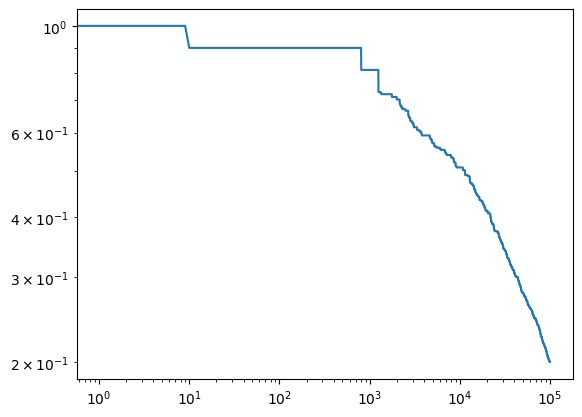

In [10]:
# Test the policy
pi_Q, errors, N = Qlearning(env, 100000, gamma=0.9, v_true=v_star)
plt.figure()
plt.loglog(errors)
play_policy(env, pi_Q, 20)


# SARSA

SARSA is an on-policy method meaning that the policy played is the same one as the policy learned.

It is like Q learning a value iteration algorithm where the policy evaluation operator is replaced by a stochastic approximation based on TD(0). However, the policy improvement step is replaced by an approximate policy improvement step where the policy is greedy with some probability (decreasing to zero as the algorithm progresses) so that to introduce some level of exploration while making sure that the algorithm converges towards the optimal policy.
More precisely, the SARSA iterations are given by:

- $Q_0 = 0_{|S| \times |A|}$, $a_1 = 0$
- For any $t \geq 0$:
  - observe state $s_t$, play $a_t$ observe next state $s_{t+1} \sim P_{a_t}(s_t)$ and reward $r_{a_t}(s_t)$
  - *Policy improvement*:
    - choose $\pi_t$ greedy with respect to $Q_t$ with probability $1 - \epsilon_t$ and uniform with probability $\epsilon_t$

  - *Policy evaluation*:
    - sample $a_{t+1} \sim \pi_t(s_{t+1})$ and set
        
  $$Q_{t+1} = Q_t + \alpha_t \bigg( r_{a_t}(s_t) + \gamma Q_t(s_{t+1}, a_{t+1}) - Q_t(s_t, a_t) \bigg) e_{s_t, a_t}$$

  where
    - $e_{i, j}$ is a vector of the canonical basis of $\mathbb{R}^{S \times A}$ (0 everywhere except in coordinate $i, j$ where it has value 1)
    - $\alpha_t = |\\{\tau \leq t : s_\tau, a_\tau = s_t, a_t \\}|^{-1}$
    - $\epsilon_t = \max_{s \in S_t, a \in A_t}|\\{\tau \leq t : s_\tau, a_\tau = s, a \\}|^{-1}$ where $S_t = \\{s \in S: \exists \tau \leq t,  s_\tau = s\\}$ and $A_t = \\{a \in A: \exists \tau \leq t,  a_\tau = a\\}$

**Remark** The choice for $\epsilon_t$ ensures that all reachable state-action pairs are visited infinitely often while $\epsilon_t \rightarrow 0$. Any choice that satisfies this condition will ensure that the returned policy converges towards the optimal policy as the number of iterations goes to infinity.

# Exercice 2

Implement SARSA

In [11]:
def SARSA(env, gamma, n_iterations, v_true=None):
  """
  Implements SARSA with TD(0)

  Parameters
  ----------
  env: Environment
    The environment to learn
  gamma: float
    Discount factor
  n_iterations: int
    Number of iterations to perform

  Return
  ------
  v_star: np array of shape (n_states)
    Optimal value function
  pi_star: np array of shape (n_states)
    Optimal (deterministic) policy
  """
  s, _ = env.reset() #Init environment
  n_states, n_actions = env.observation_space.n, env.action_space.n
  errors = [] #errors if v_true
  Q = np.zeros((n_states, n_actions)) #Q-function
  N = np.zeros((n_states, n_actions)) #Counter
  a = 0


  # Iterate over time
  for t in range(n_iterations):
    # Interact with the environment
    next_state, reward, terminated, truncated, _ = env.step(a)
    N[s, a] += 1

    # Epsilon-Greedy
    proba = 1/np.min(N[N > 0])
    if np.random.rand() < proba:
      next_action = np.random.choice(np.arange(n_actions)) #Random
    else:
      next_action = np.argmax(Q[next_state, :])
    Q[s, a] += (reward + gamma * Q[next_state, next_action] - Q[s, a]) / N[s, a]
    s = next_state
    a = next_action

    if terminated or truncated:
      s, _ = env.reset()
      proba = 1/np.min(N[N > 0])
      if np.random.rand() < proba:
        a = np.random.choice(np.arange(n_actions)) #Random
      else:
        a = np.argmax(Q[next_state, :])

    if v_true is not None:
      errors.append(np.max(np.abs(np.max(Q, axis=1) - v_true)))

  return np.argmax(Q, axis=1), np.array(errors), N


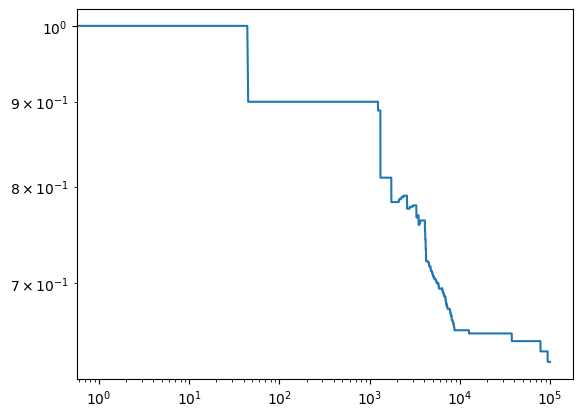

In [12]:
n_iterations = 100000
pi_sarsa, errors, N = SARSA(env, 0.9, n_iterations, v_star)
plt.loglog(errors)

In [13]:
play_policy(env, pi_sarsa, 20)

# SARSA($\lambda$)

SARSA($\lambda$) is a variation of SARSA where the online version of TD($\lambda$) is used instead of $TD(0)$.

The iterations are given by
- $Q_0 = 0_{|S| \times |A|}$, $a_1 = 0$, $E_0 = 0_{|S| \times |A|}$
- For any $t \geq 0$:
  - observe state $s_t$, play $a_t$ observe next state $s_{t+1} \sim P_{a_t}(s_t)$ and reward $r_{a_t}(s_t)$
  - *Policy improvement*:
    - choose $\pi_t$ greedy with respect to $Q_t$ with probability $1 - \epsilon_t$ and uniform with probability $\epsilon_t$

  - *Policy evaluation*:
    - sample $a_{t+1} \sim \pi_t(s_{t+1})$ and set

  $$ E_t = \gamma \lambda E_{t-1} + e_{s_t, a_t}$$
        
  $$Q_{t+1} = Q_t + \alpha_t \odot \bigg( r_{a_t}(s_t) + \gamma Q_t(s_{t+1}, a_{t+1}) - Q_t(s_t, a_t) \bigg) E_t$$

  where
    - $e_{i, j}$ is a vector of the canonical basis of $\mathbb{R}^{S \times A}$ (0 everywhere except in coordinate $i, j$ where it has value 1)
    - $\alpha_t(s, a) = \min(|\\{\tau \leq t : s_\tau, a_\tau = s, a \\}|^{-1}, 1)$ for all $s \in S, a \in A$
    - $\epsilon_t = \max_{s \in S_t, a \in A_t}|\\{\tau \leq t : s_\tau, a_\tau = s, a \\}|^{-1}$ where $S_t = \\{s \in S: \exists \tau \leq t,  s_\tau = s\\}$ and $A_t = \\{a \in A: \exists \tau \leq t,  a_\tau = a\\}$

# Exercice 3

Implement SARSA($\lambda$)

In [22]:
def SARSA_lambda(env, gamma, n_iterations, l, v_true=None):
  """
  Implements SARSA with TD(lambda)

  Parameters
  ----------
  env: Environment
    The environment to learn
  gamma: float
    Discount factor
  n_iterations: int
    Number of iterations to perform
  l: float
    Lambda parameter in TD(lambda)

  Return
  ------
  v_star: np array of shape (n_states)
    Optimal value function
  pi_star: np array of shape (n_states)
    Optimal (deterministic) policy
  """
  s, _ = env.reset() #Init environment
  n_states, n_actions = env.observation_space.n, env.action_space.n
  errors = [] #errors if v_true
  Q = np.zeros((n_states, n_actions)) #Q-function
  N = np.zeros((n_states, n_actions)) #Counter
  E = np.zeros((n_states, n_actions)) #E
  a = 0


  # Iterate over time
  for t in range(n_iterations):
    # Interact with the environment
    next_state, reward, terminated, truncated, _ = env.step(a)
    N[s, a] += 1

    # Epsilon-Greedy
    proba = 1/np.min(N[N > 0])
    if np.random.rand() < proba:
      next_action = np.random.choice(np.arange(n_actions)) #Random
    else:
      next_action = np.argmax(Q[next_state, :])
    E = l * gamma * E
    E[s, a] += 1
    Q += E * (reward + gamma * Q[next_state, next_action] - Q[s, a]) * np.minimum(1 / N, 1)
    s = next_state
    a = next_action

    if terminated or truncated:
      s, _ = env.reset()
      proba = 1/np.min(N[N > 0])
      if np.random.rand() < proba:
        a = np.random.choice(np.arange(n_actions)) #Random
      else:
        a = np.argmax(Q[next_state, :])
      E = np.zeros((n_states, n_actions))

    if v_true is not None:
      errors.append(np.max(np.abs(np.max(Q, axis=1) - v_true)))

  return np.argmax(Q, axis=1), np.array(errors), N

<ipython-input-22-4e098a4ccb97>:46: RuntimeWarning: divide by zero encountered in divide
  Q += E * (reward + gamma * Q[next_state, next_action] - Q[s, a]) * np.minimum(1 / N, 1)


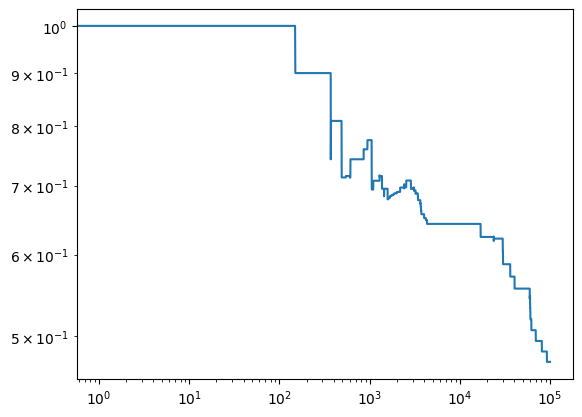

In [23]:
n_iterations = 100000
pi_sarsal, errors, N = SARSA_lambda(env, 0.9,n_iterations, 0.5, v_star)
plt.loglog(errors)

In [24]:
play_policy(env, pi_sarsa, 20)